In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from typing import Tuple, List
# new import statements
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Retailrocket recommender system dataset

Source: https://www.kaggle.com/retailrocket/ecommerce-dataset

Load the dataset files.

In [2]:
events = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'events.csv'))
item_properties = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'item_properties_part1.csv'))
category_tree = pd.read_csv(os.path.join(\
    '..', 'timeseries_lec_data', 'category_tree.csv'))

In [3]:
events['event_datetime'] = pd.to_datetime(events['timestamp'], unit='ms')
events['event_date'] = events['event_datetime'].dt.date
events

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02
...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01


In [4]:
item_properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
10999994,1439694000000,86599,categoryid,618
10999995,1435460400000,153032,1066,n1020.000 424566
10999996,1440298800000,421788,888,35975 856003 37346
10999997,1437879600000,159792,400,n552.000 639502 n720.000 424566


In [5]:
category_tree

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
...,...,...
1664,49,1125.0
1665,1112,630.0
1666,1336,745.0
1667,689,207.0


## Statistical model for timeseries analysis

### 1. Exponential Moving Average (EMA)
EMA is a quantitative technique used as a forecasting model for time series analysis. It is a statistical method used to smooth time-series data by giving more weight to recent observations and less weight to older ones. It's useful in scenarios where recent data points are considered more relevant and informative. Typical use case scenarios include financial time-series analysis or e-commerce product popularity prediction.

### pandas ewm

- Documentation: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html.

#### Q5: Use an Exponential Moving Average (EMA) model to calculate the average itemid view counts per category in the events dataset. Calculate the EMA for each category over a specified span.

In [6]:
category_items = item_properties[item_properties['property'] == 'categoryid'][['itemid', 'value']]
# 'value' column contains the category IDs, so let's rename value to categoryid
category_items.columns = ['itemid', 'categoryid']  
category_items

,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47
...,...,...
10999880,441523,1167
10999917,250848,769
10999932,116380,1509
10999960,84186,209


In [7]:
category_items['categoryid'] = category_items['categoryid'].astype(int)

In [8]:
categories = category_items['categoryid'].unique()
categories

array([1338, 1277, 1059, ...,  934,  480, 1354], shape=(1196,))

In [9]:
results = pd.DataFrame(columns=["timestamp", "categoryid", "ema"])
results

,timestamp,categoryid,ema


In [10]:
results_list = []

for category in tqdm(categories, total=len(categories)):
    # get the itemids associated with the current category
    category_items_for_category = category_items[category_items['categoryid'] == category]['itemid']
    
    # filter the events dataset for the current category's items and 'view' events
    category_events = events[(events['itemid'].isin(category_items_for_category)) & (events['event'] == 'view')]
    
    # group by timestamp to get the view counts per timestamp
    view_counts = category_events.groupby("timestamp").size()
    
    # apply the Exponential Moving Average (EMA) with a span of 16 to smooth the view counts
    ema_values = view_counts.ewm(span=16, adjust=False).mean()
    
    # store the results with the EMA values for the category
    category_results = pd.DataFrame({
        "timestamp": ema_values.index,
        "categoryid": category,
        "ema": ema_values.values
    })
    
    # append the current category's results to the results list
    results_list.append(category_results)

# concatenate all the results into a single DataFrame
results = pd.concat(results_list, ignore_index=True)

100%|██████████████████████████████████████████████████| 1196/1196 [05:34<00:00,  3.57it/s]


In [11]:
results

,timestamp,categoryid,ema
0,1430649263692,1338,1.0
1,1430649323031,1338,1.0
2,1430659604240,1338,1.0
3,1430668046337,1338,1.0
4,1430668062168,1338,1.0
...,...,...,...
1459107,1438633754909,480,1.0
1459108,1440457508755,480,1.0
1459109,1442344855260,480,1.0
1459110,1442169053784,1354,1.0


### 2. ARIMA (Autoregressive Integrated Moving Average) model

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

Autocorrelation and partial autocorrelation are statistical measures that help analyze the relationship between a time series and its lagged values. They help identify patterns, trends, and dependencies in the data, which are crucial for model selection and evaluation.

### Autocorrelation

- Autocorrelation measures the linear relationship between a time series and its lagged values. In simpler terms, it assesses how much the current value of a series depends on its past values. 
- Used for identifying the order of a moving average (MA) process.
- Represents the overall correlation structure of the time series.
- Autocorrelation measures the linear relationship between an observation and its previous observations at different lags.
- Use case:
    - To identify repeated patterns (seasonality).
    - To assess whether a time series is random or has some dependency.
    - To decide if a time series has autoregressive (AR) components.

### Partial Autocorrelation
- Partial autocorrelation removes the influence of intermediate lags, providing a clearer picture of the direct relationship between a variable and its past values. Unlike autocorrelation, partial autocorrelation focuses on the direct correlation at each lag.
- Used for identifying the order of an autoregressive (AR) process.
- Highlights the direct relationships between observations at specific lags.
- Partial Autocorrelation measures the direct linear relationship between an observation and its previous observations at a specific lag, excluding the contributions from intermediate lags.
- Use case:
    - To determine the order of an autoregressive (AR) process.
    - To identify the number of lags that have a significant and direct impact on the current value.

In [14]:
events_with_categories = pd.merge(events, category_items, on="itemid", how="left")
events_with_categories

,timestamp,visitorid,event,itemid,transactionid,event_datetime,event_date,categoryid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,1173.0
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,NaN
...,...,...,...,...,...,...,...,...
4439576,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,2015-08-01,NaN
4439577,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,2015-08-01,1616.0
4439578,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,2015-08-01,969.0
4439579,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,2015-08-01,NaN


In [15]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_datetime', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

,event_datetime,categoryid,view_count
0,2015-05-03 03:00:28.399,421.0,5
1,2015-05-03 03:00:28.399,1674.0,13
2,2015-05-03 03:00:33.686,1339.0,1
3,2015-05-03 03:00:36.210,368.0,1
4,2015-05-03 03:00:40.988,683.0,1
...,...,...,...
1459107,2015-09-18 02:58:54.195,1196.0,1
1459108,2015-09-18 02:59:12.365,1293.0,1
1459109,2015-09-18 02:59:13.842,956.0,1
1459110,2015-09-18 02:59:34.109,491.0,1


In [17]:
category_totals = (
    grouped_data.groupby('categoryid')['view_count']
    .sum()
    .reset_index()
    .sort_values('view_count', ascending=False)
)
category_totals

,categoryid,view_count
1065,1613.0,233544
326,491.0,180269
738,1120.0,129415
1000,1509.0,64328
843,1277.0,58159
...,...,...
961,1449.0,1
846,1281.0,1
82,129.0,1
60,91.0,1


In [19]:
category_totals.head(20)['categoryid']

1065    1613.0
326      491.0
738     1120.0
1000    1509.0
843     1277.0
432      642.0
767     1167.0
690     1051.0
985     1483.0
541      822.0
472      707.0
166      256.0
927     1402.0
929     1404.0
366      546.0
281      429.0
330      496.0
625      959.0
808     1228.0
868     1312.0
Name: categoryid, dtype: float64

In [20]:
top_categories = category_totals.head(20)['categoryid'].values
top_categories

array([1613.,  491., 1120., 1509., 1277.,  642., 1167., 1051., 1483.,
        822.,  707.,  256., 1402., 1404.,  546.,  429.,  496.,  959.,
       1228., 1312.])

In [21]:
grouped_data

,event_datetime,categoryid,view_count
0,2015-05-03 03:00:28.399,421.0,5
1,2015-05-03 03:00:28.399,1674.0,13
2,2015-05-03 03:00:33.686,1339.0,1
3,2015-05-03 03:00:36.210,368.0,1
4,2015-05-03 03:00:40.988,683.0,1
...,...,...,...
1459107,2015-09-18 02:58:54.195,1196.0,1
1459108,2015-09-18 02:59:12.365,1293.0,1
1459109,2015-09-18 02:59:13.842,956.0,1
1459110,2015-09-18 02:59:34.109,491.0,1


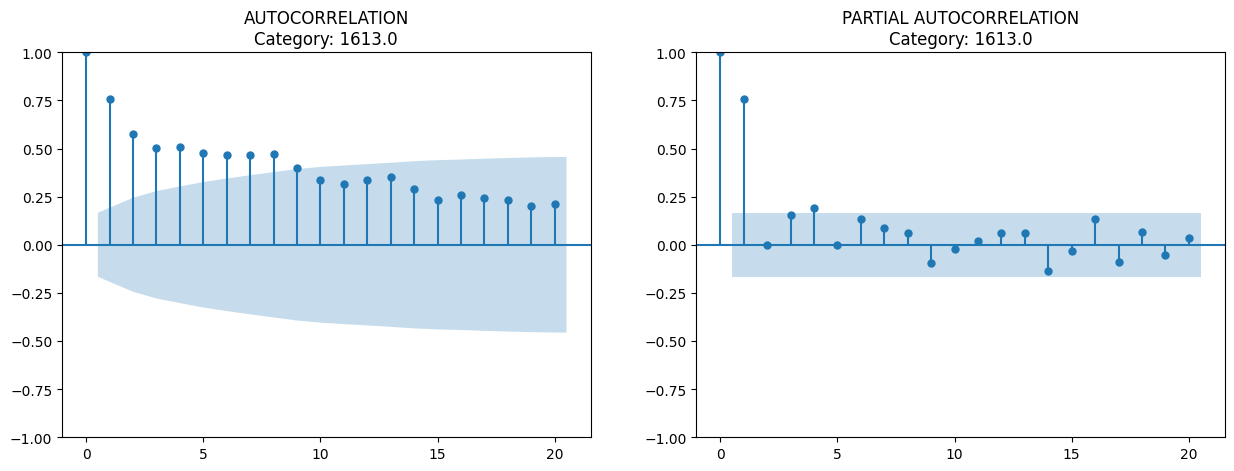

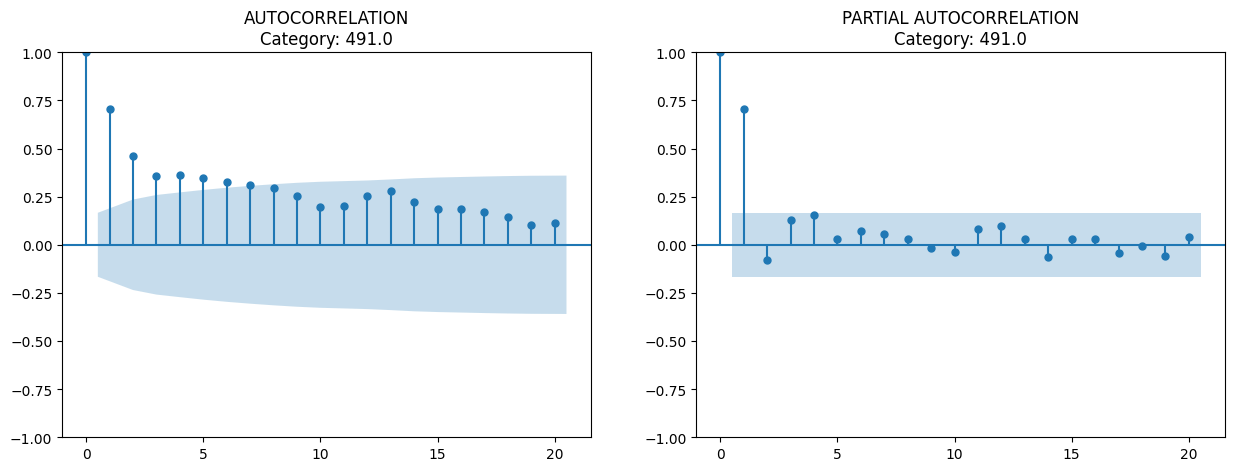

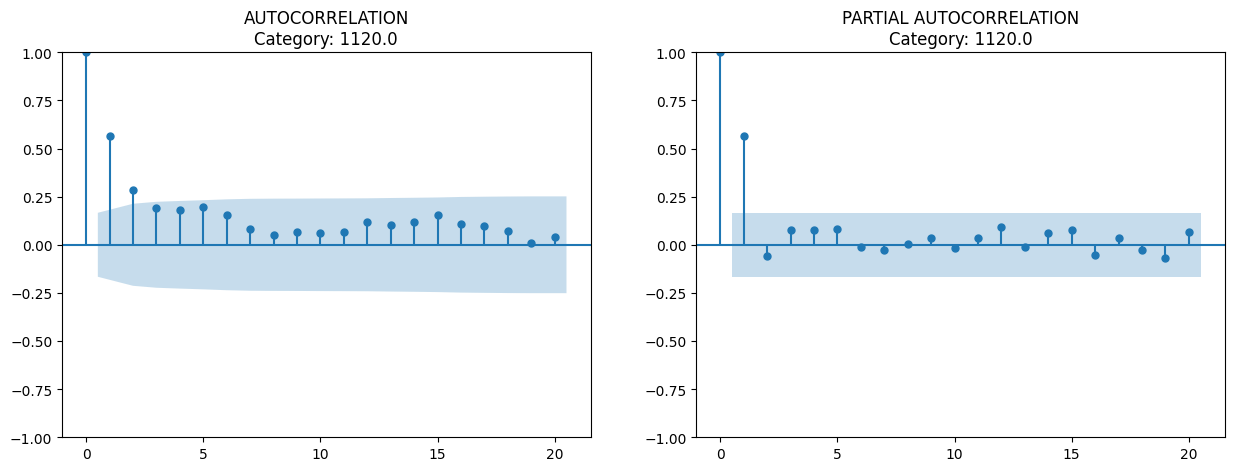

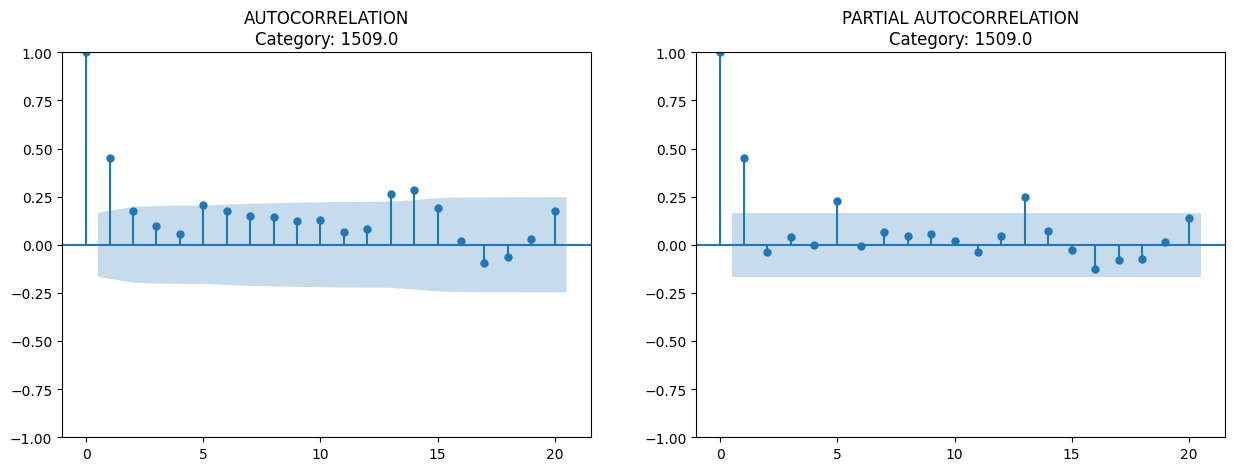

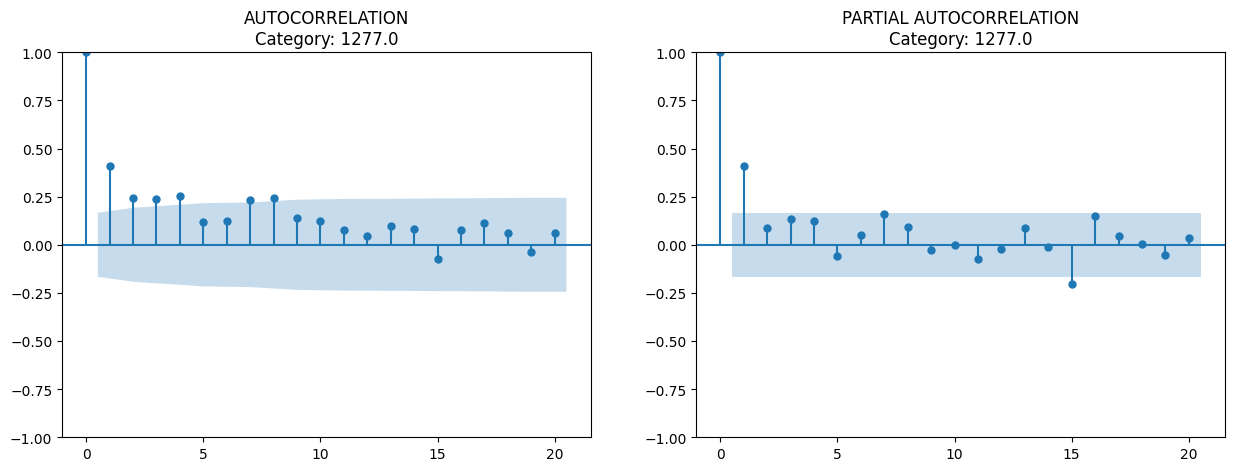

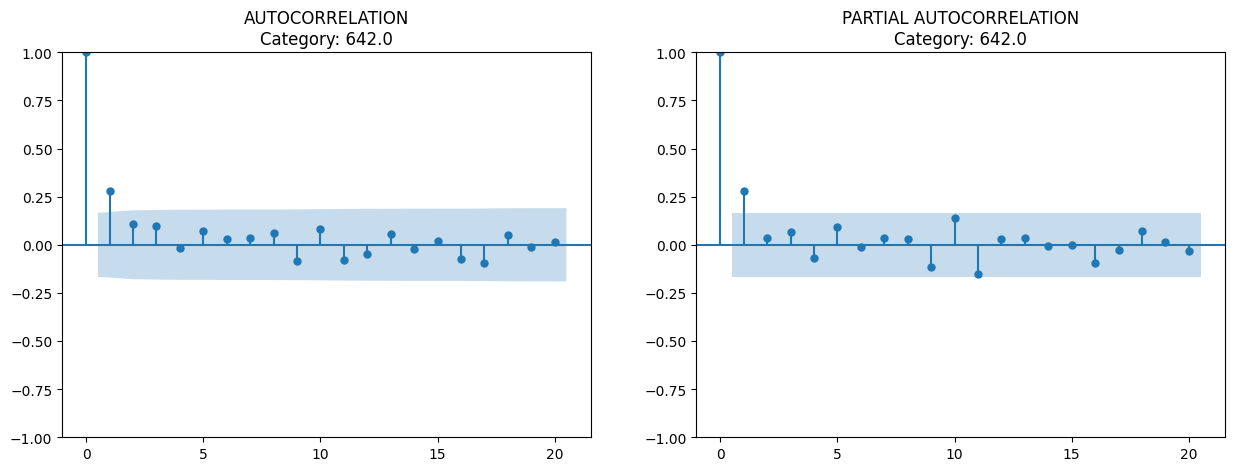

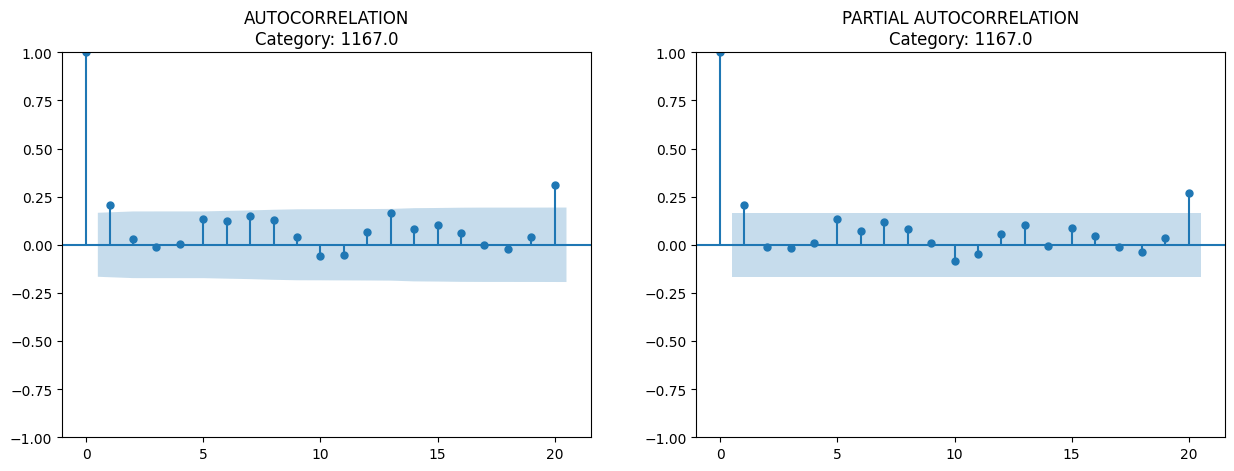

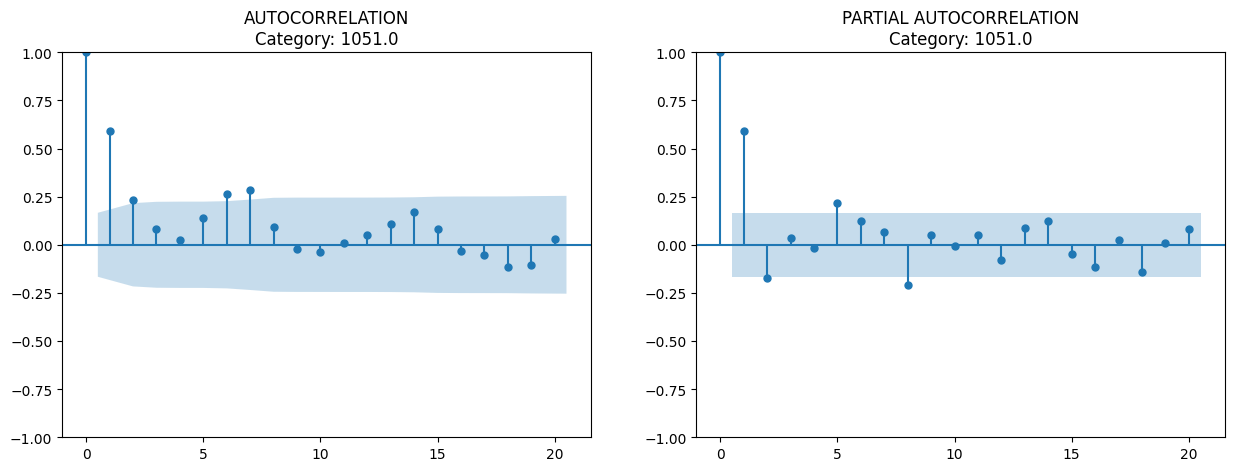

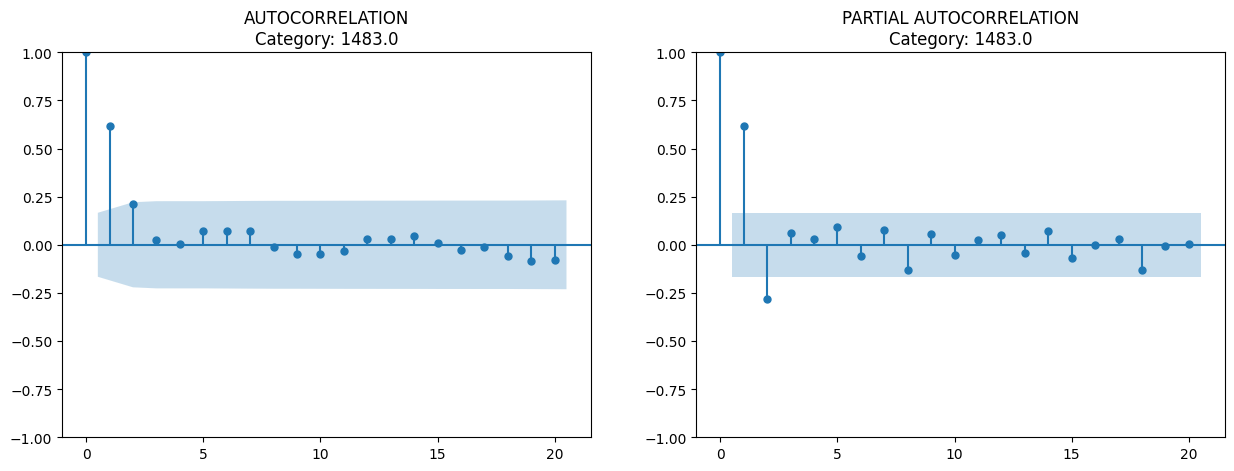

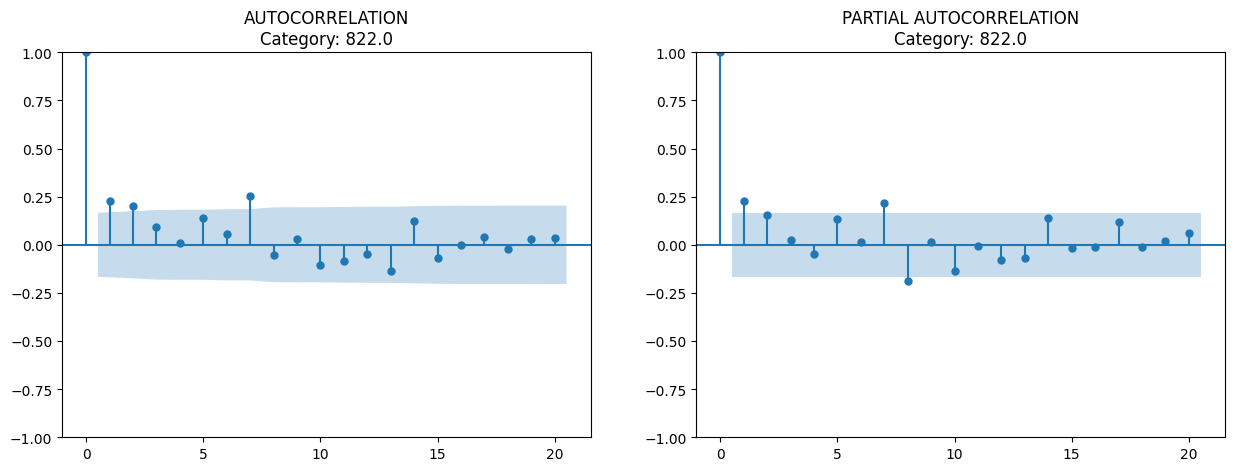

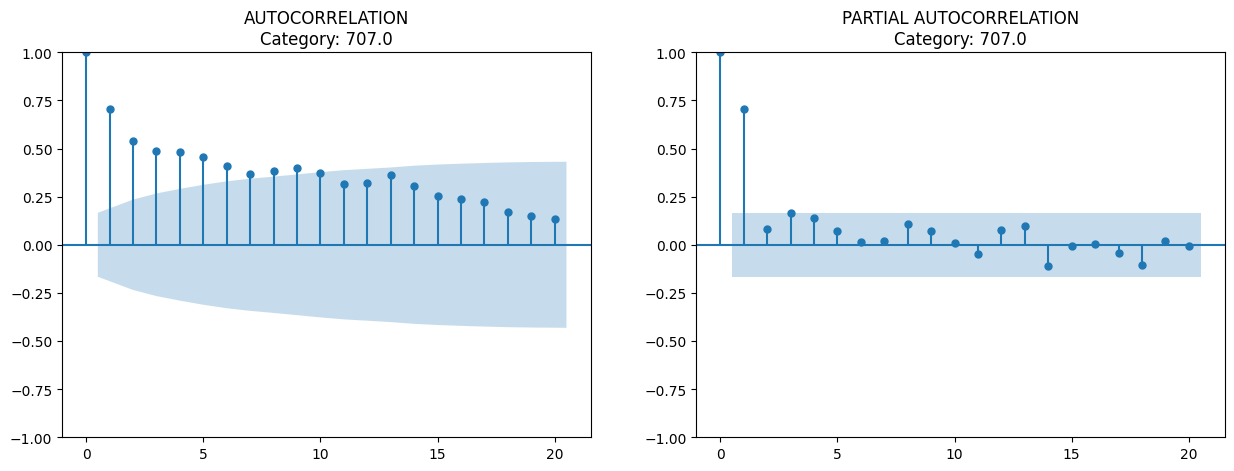

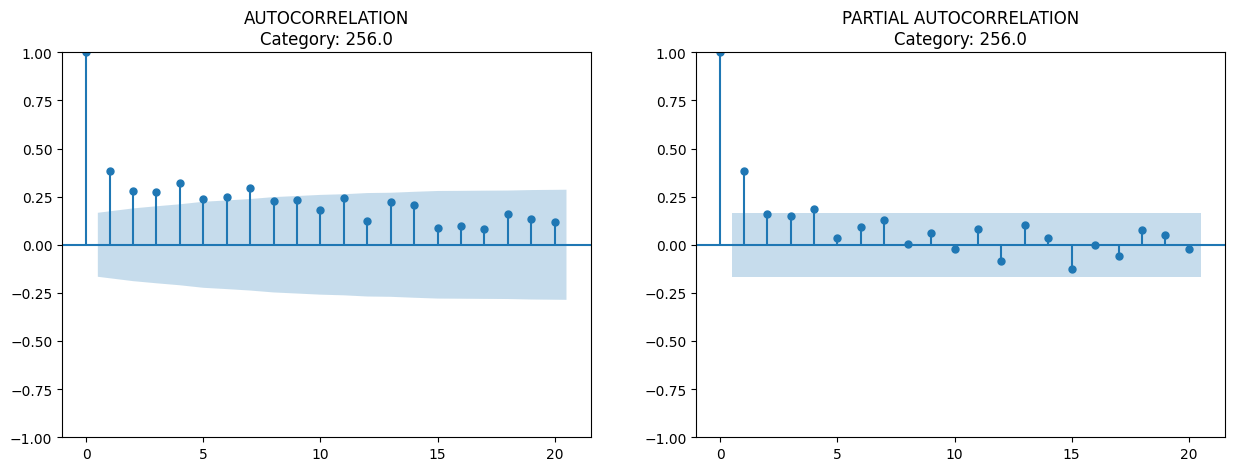

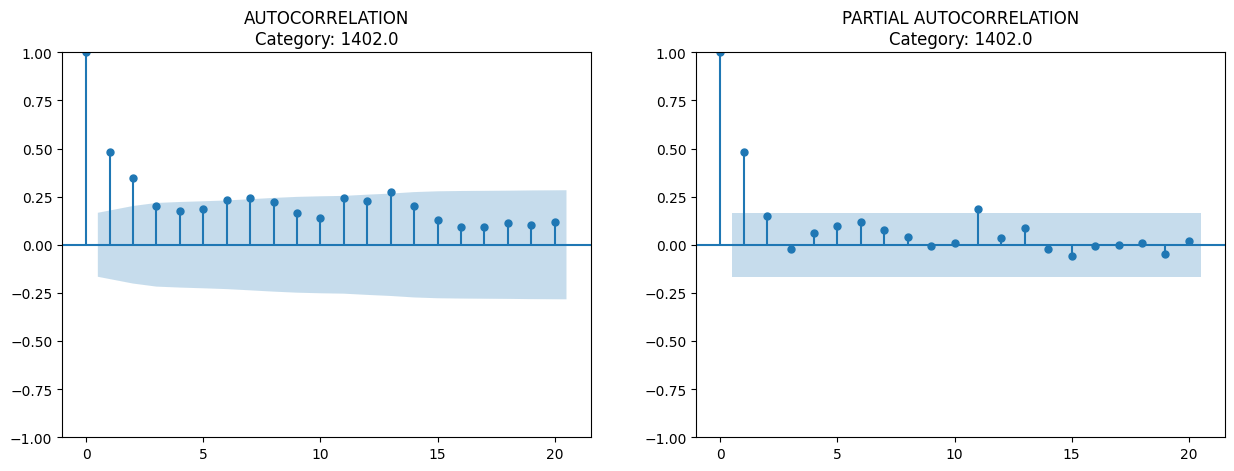

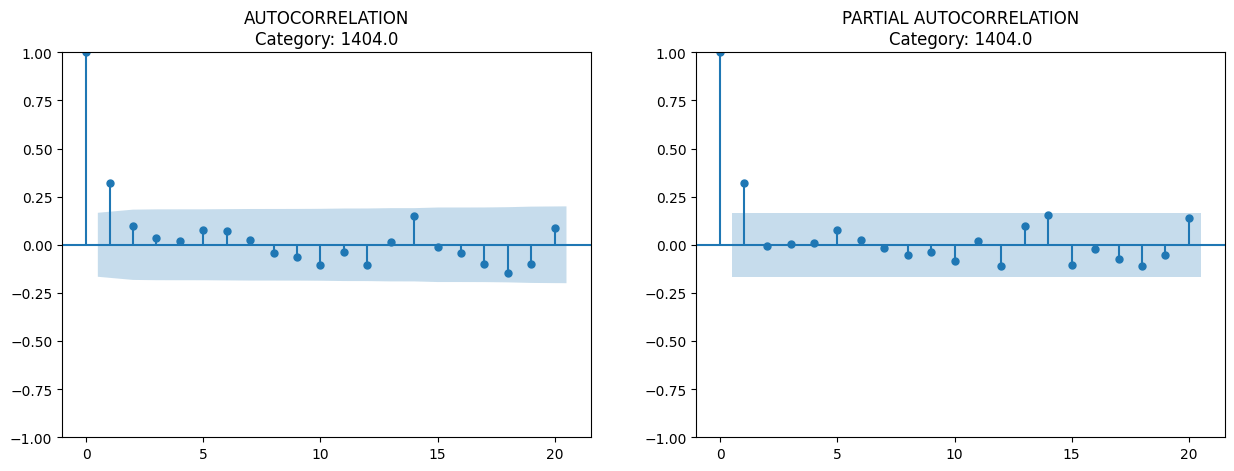

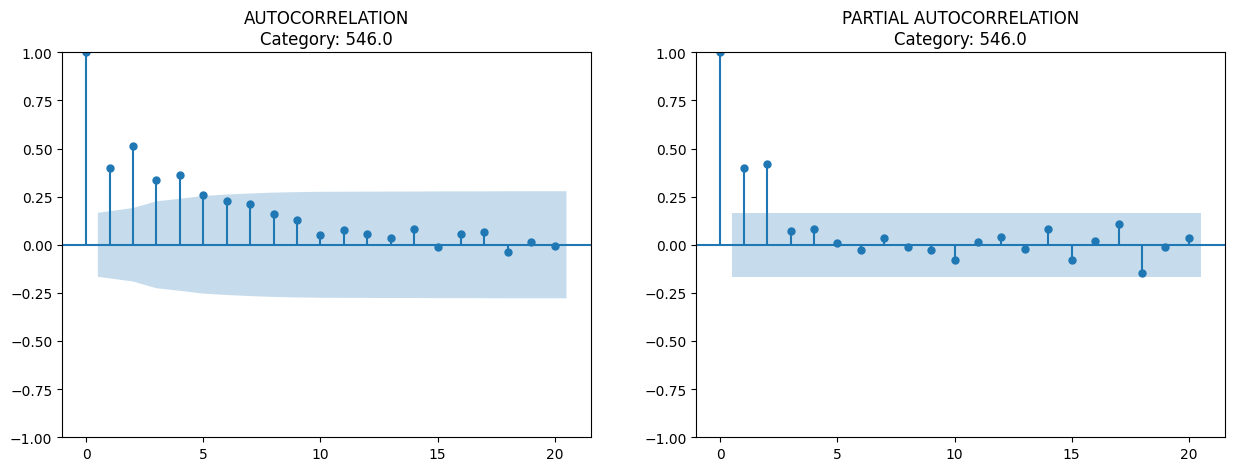

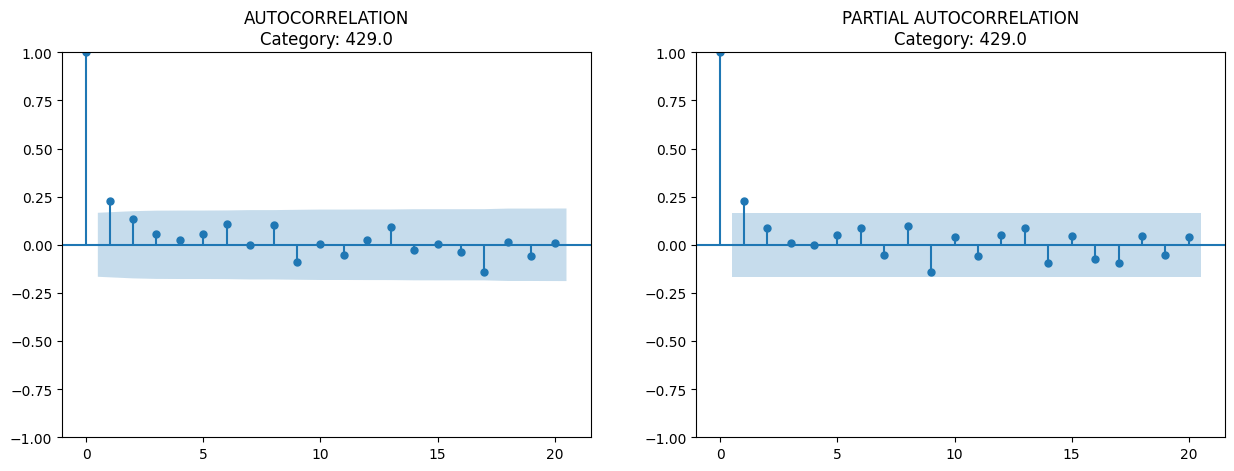

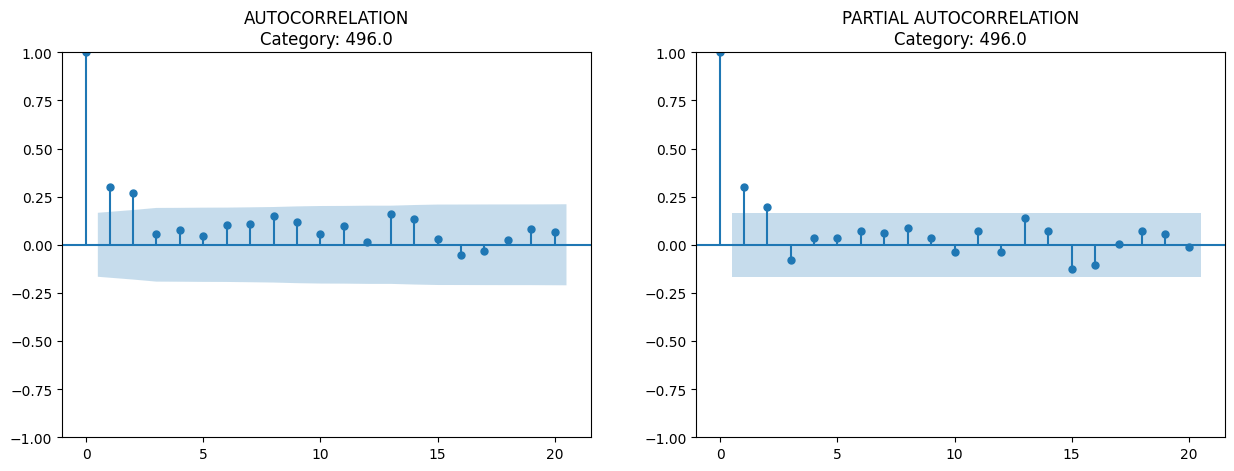

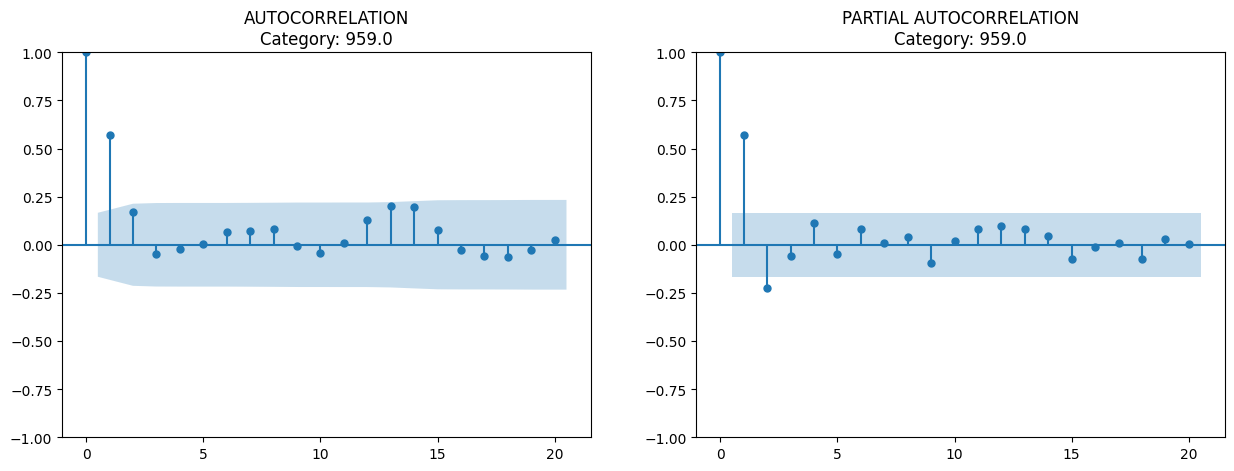

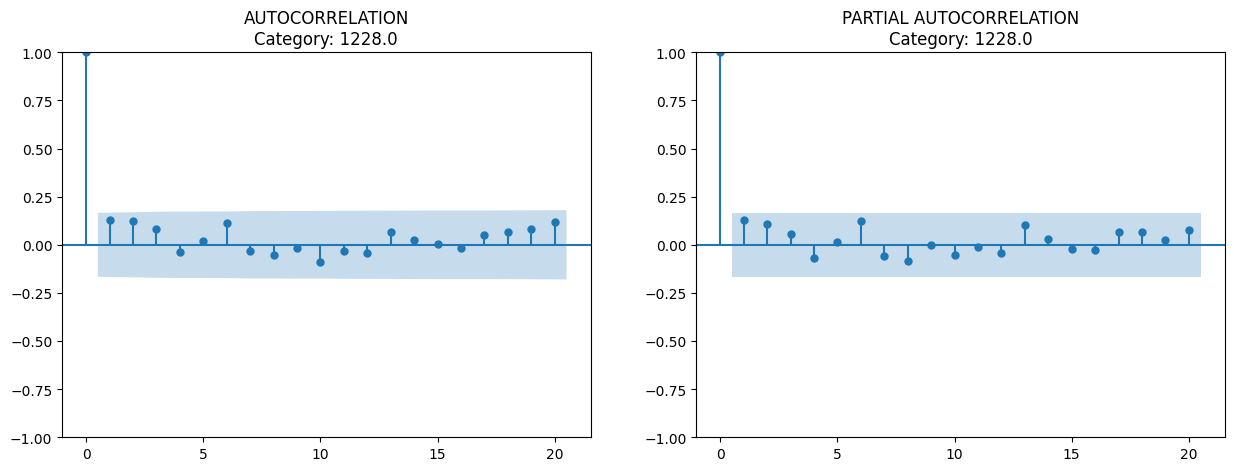

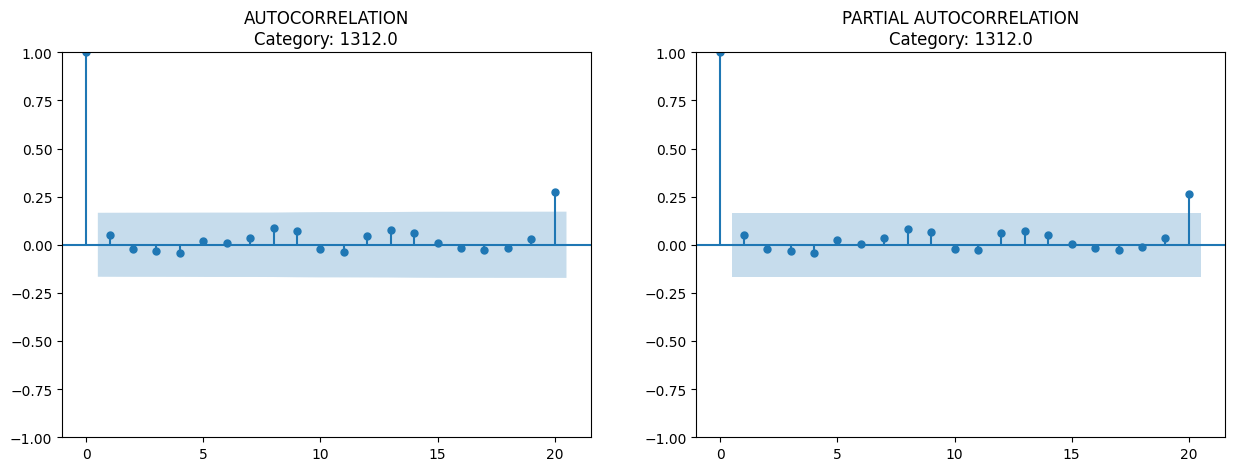

In [22]:
for num, category in enumerate(top_categories):
    try:
        category_data = grouped_data[grouped_data['categoryid'] == category]
        
        # Resample to daily view counts
        category_daily = (
            category_data.set_index('event_datetime')
            .resample('D')
            .sum()
            .fillna(0)  # Fill missing days with 0 view counts
        )
        
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot ACF and PACF
        plot_acf(category_daily['view_count'], lags=20, ax=ax[0], title=f"AUTOCORRELATION\nCategory: {category}")
        plot_pacf(category_daily['view_count'], lags=20, ax=ax[1], title=f"PARTIAL AUTOCORRELATION\nCategory: {category}")
        
        plt.show()
    except Exception as e:
        print(f"Error processing category {category}: {e}")
        pass

plt.close('all')

In [ ]:
grouped_data = (
    events_with_categories[events_with_categories['event'] == 'view']
    .groupby(['event_date', 'categoryid'])
    .size()
    .reset_index(name='view_count') 
)
grouped_data

### ACF and PACF for the whole view count timeseries

In [25]:
grouped_data['event_date'] = grouped_data['event_datetime'].dt.date
grouped_data

,event_datetime,categoryid,view_count,event_date
0,2015-05-03 03:00:28.399,421.0,5,2015-05-03
1,2015-05-03 03:00:28.399,1674.0,13,2015-05-03
2,2015-05-03 03:00:33.686,1339.0,1,2015-05-03
3,2015-05-03 03:00:36.210,368.0,1,2015-05-03
4,2015-05-03 03:00:40.988,683.0,1,2015-05-03
...,...,...,...,...
1459107,2015-09-18 02:58:54.195,1196.0,1,2015-09-18
1459108,2015-09-18 02:59:12.365,1293.0,1,2015-09-18
1459109,2015-09-18 02:59:13.842,956.0,1,2015-09-18
1459110,2015-09-18 02:59:34.109,491.0,1,2015-09-18


In [26]:
per_day_data = grouped_data.groupby('event_date')['view_count'].sum().reset_index()
per_day_data

,event_date,view_count
0,2015-05-03,16405
1,2015-05-04,22200
2,2015-05-05,25861
3,2015-05-06,26558
4,2015-05-07,27054
...,...,...
134,2015-09-14,20405
135,2015-09-15,20149
136,2015-09-16,11647
137,2015-09-17,11968


### ARIMA `q` determination

- `q`: The order of the Moving Average (MA) Term
- What is `q`? The number of lagged forecast errors included in the model.
- How to determine it from ACF plot?
    - Look for a significant spike and where it cuts off. The lag at the cut-off point indicates q.

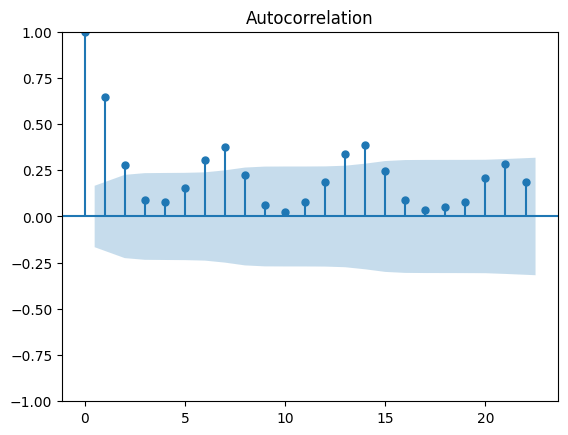

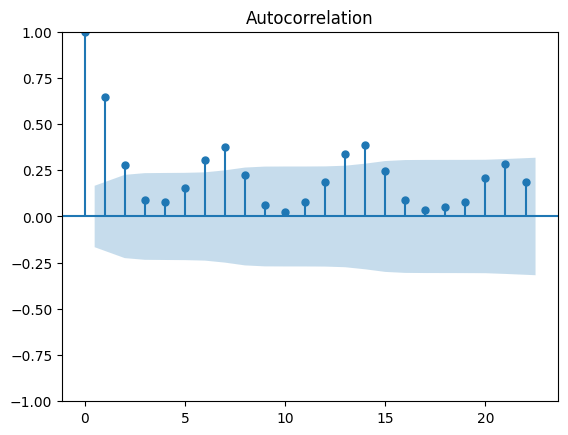

In [27]:
plot_acf(per_day_data['view_count'])

### ARIMA `p` determination

- `p`: The order of the Autoregressive (AR) Term
- What is `p`? The number of lagged observations used to predict the series.
- How to determine it from PACF plot?
    - Look for a significant spike (above the confidence interval) and where it cuts off. The lag at the cut-off point indicates p.

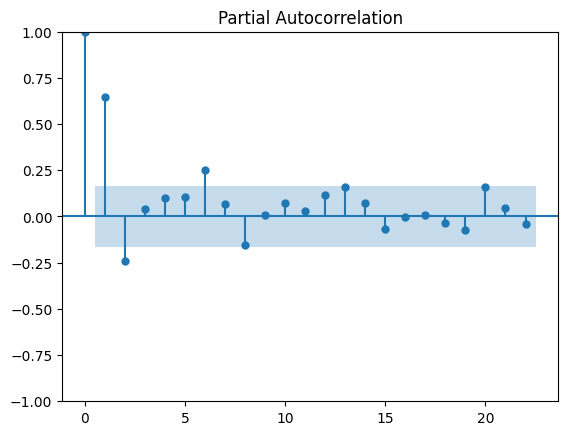

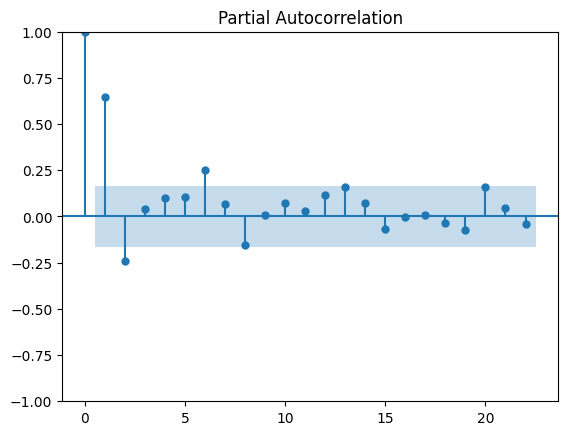

In [28]:
plot_pacf(per_day_data['view_count'])

Computing autocorr value without plot.

In [ ]:
autocorr_values = per_day_data['view_count'].autocorr()
print("Autocorrelation:", autocorr_values)